In [1]:
import json

# prepare validation and test sets

from src.processing import prepare_somos_data

prepare_somos_data(
    listeners=10,
    systems=10,
    texts=50,
    num_iterations=1000,
    somos_dir='data/SOMOS',
    output_dir='data/somos_prepared',
    random_seed=1234
) 

2024-01-06 20:01:44.881158 :: VALIDATION SET PREPARED :: 57 SAMPLES
VAL min wasserstein distance: 0.03450007855828836
validation locales
us: 35
ca: 13
gb: 9
2024-01-06 20:02:17.552154 :: TEST SET PREPARED :: 54 SAMPLES
TEST min wasserstein distance: 0.017990691202849227
test locales
gb: 21
ca: 21
us: 12
2024-01-06 20:02:17.553615 :: SAVED TO data/somos_prepared


In [1]:
# define MOSNet model baseline

from src.mosnet.models import MOSNet, ProsAlignMOSNet
from src.mosnet.train import train_mosnet

MOSNET_STFT_PARAMS = {
    'n_fft': 512,
    'hop_length': 256
}

BASELINE_MOSNET_PARAMS = {
    'cnn_channels': [16, 32, 64, 128],
    'cnn_kernel_size': 3,
    'blstm_hidden_size': 128,
    'fc_hidden_size': 128,
    'fc_dropout': 0.3
}

DEVICE = 'cuda:0'
TRAIN_DIR = 'data'
VAL_PATH = 'data/somos_prepared/validation_set.csv'
TEST_PATH = 'data/somos_prepared/test_set.csv'
TRANSCRIPTS_PATH = 'data/SOMOS/all_transcripts.txt'
AUDIOS_PATH = 'data/SOMOS/audios'

In [2]:
# train baseline MOSNet model

model = MOSNet(
    stft_params=MOSNET_STFT_PARAMS,
    model_params=BASELINE_MOSNET_PARAMS
).to(DEVICE)

train_mosnet(
    model=model, 
    train_params={
        'data_dir': TRAIN_DIR,
        'epochs': 50,
        'batch_size': 64,
        'num_workers': 5,
        'learning_rate': 1e-4
    },
    validation_params={
        'data_path': VAL_PATH,
        'transcripts_path': TRANSCRIPTS_PATH,
        'audios_path': AUDIOS_PATH
    },
    device=DEVICE,
    runs_dir='runs/prod/mosnet',
    model_output_path='pretrained/mosnet.pt'
)

2024-01-15 09:45:07.721241 :: START RUN
2024-01-15 09:45:53.853511 :: EPOCH 1 :: MOSNET TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.0558, srcc: 0.0603, mse: 0.3141, ktau: 0.0405 } :: SYSTEM :: { lcc: 0.1053, srcc: 0.1060, mse: 0.3293, ktau: 0.0759 }
2024-01-15 09:45:55.633126 :: MOSNET VALIDATION :: METRICS :: 
UTTERANCE :: { lcc: 0.0134, srcc: -0.0194, mse: 1.4554, ktau: -0.0164 } :: SYSTEM :: { lcc: 0.2191, srcc: 0.2957, mse: 1.2229, ktau: 0.2590 }
2024-01-15 09:46:41.699966 :: EPOCH 2 :: MOSNET TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.1684, srcc: 0.1605, mse: 0.3090, ktau: 0.1080 } :: SYSTEM :: { lcc: 0.1341, srcc: 0.1039, mse: 0.3028, ktau: 0.0719 }
2024-01-15 09:46:42.985796 :: MOSNET VALIDATION :: METRICS :: 
UTTERANCE :: { lcc: 0.1581, srcc: 0.1135, mse: 1.4418, ktau: 0.0776 } :: SYSTEM :: { lcc: 0.2682, srcc: 0.2035, mse: 1.2160, ktau: 0.1798 }
2024-01-15 09:47:29.217161 :: EPOCH 3 :: MOSNET TRAIN :: METRICS :: 
UTTERANCE :: { lcc: 0.2468, srcc: 0.2484, mse: 0.3016, ktau: 0.16

MOSNet(
  (stft): Spectrogram()
  (cnn): MOSCNN(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 3), padding=(1, 1))
        (5): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 3), padding=(1, 1))
        (5): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), s

In [8]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_columns(fname, title):
    results = pd.read_csv(fname)

    fig, axs = plt.subplots(math.ceil(len(results.columns) / 2), 2, figsize=(15, 15))
    axs = np.ravel(axs)

    for i, column in enumerate(results.columns):
        if column != 'epoch':
            results[column].plot(kind='line', ax=axs[i], title=f'{title}: {column}')

    plt.show()

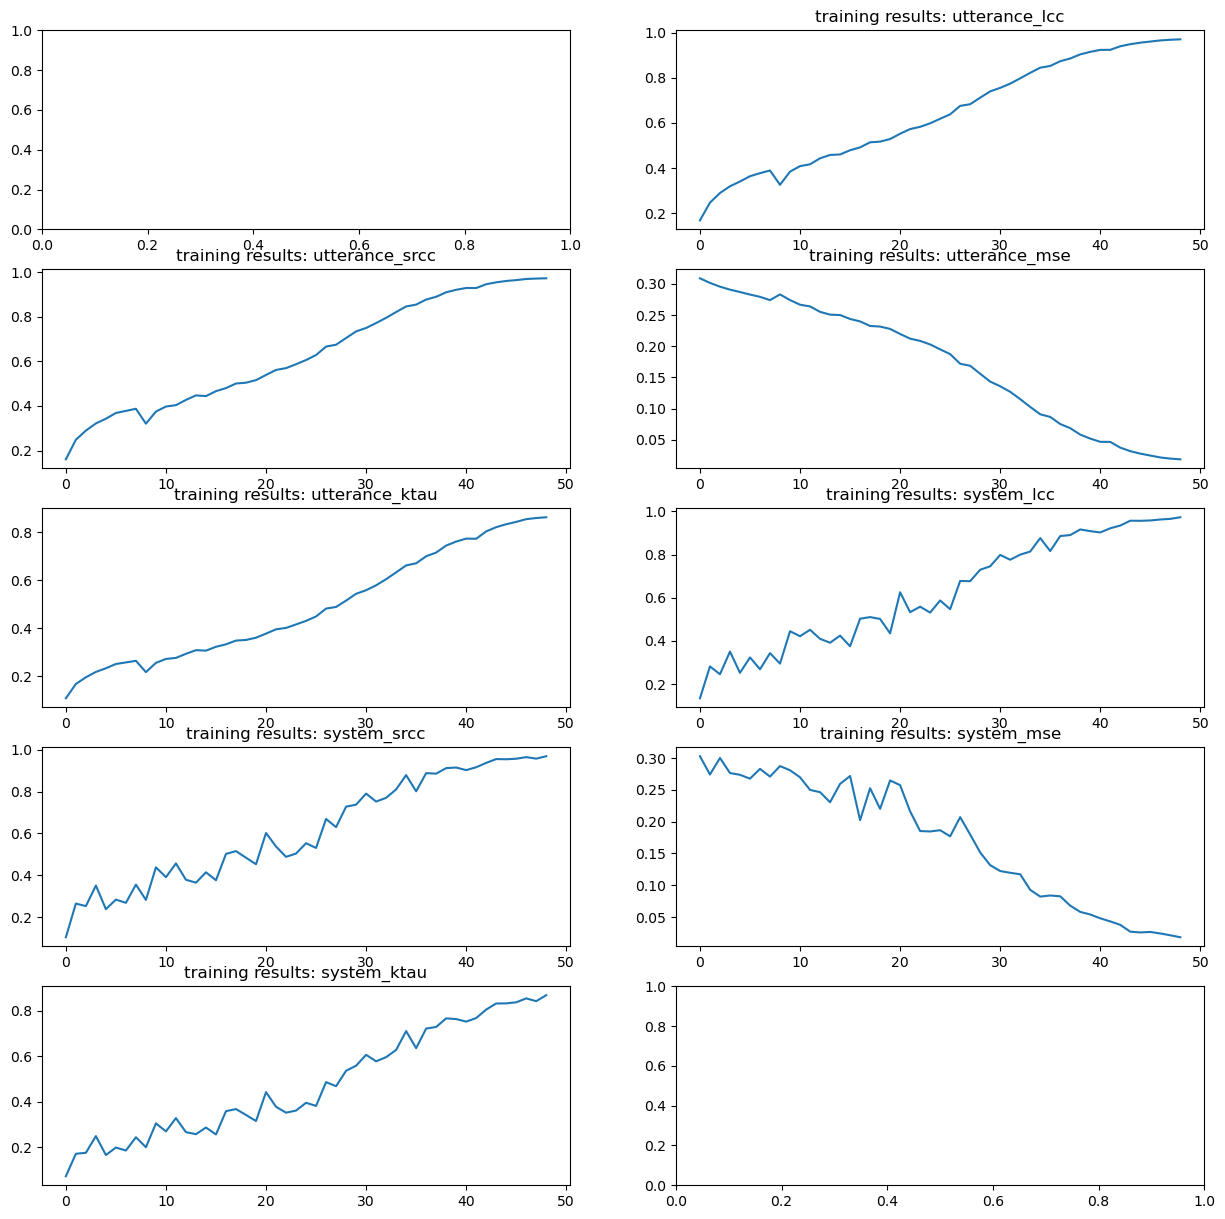

In [9]:
plot_columns('runs/prod/mosnet/train.csv', 'training results')

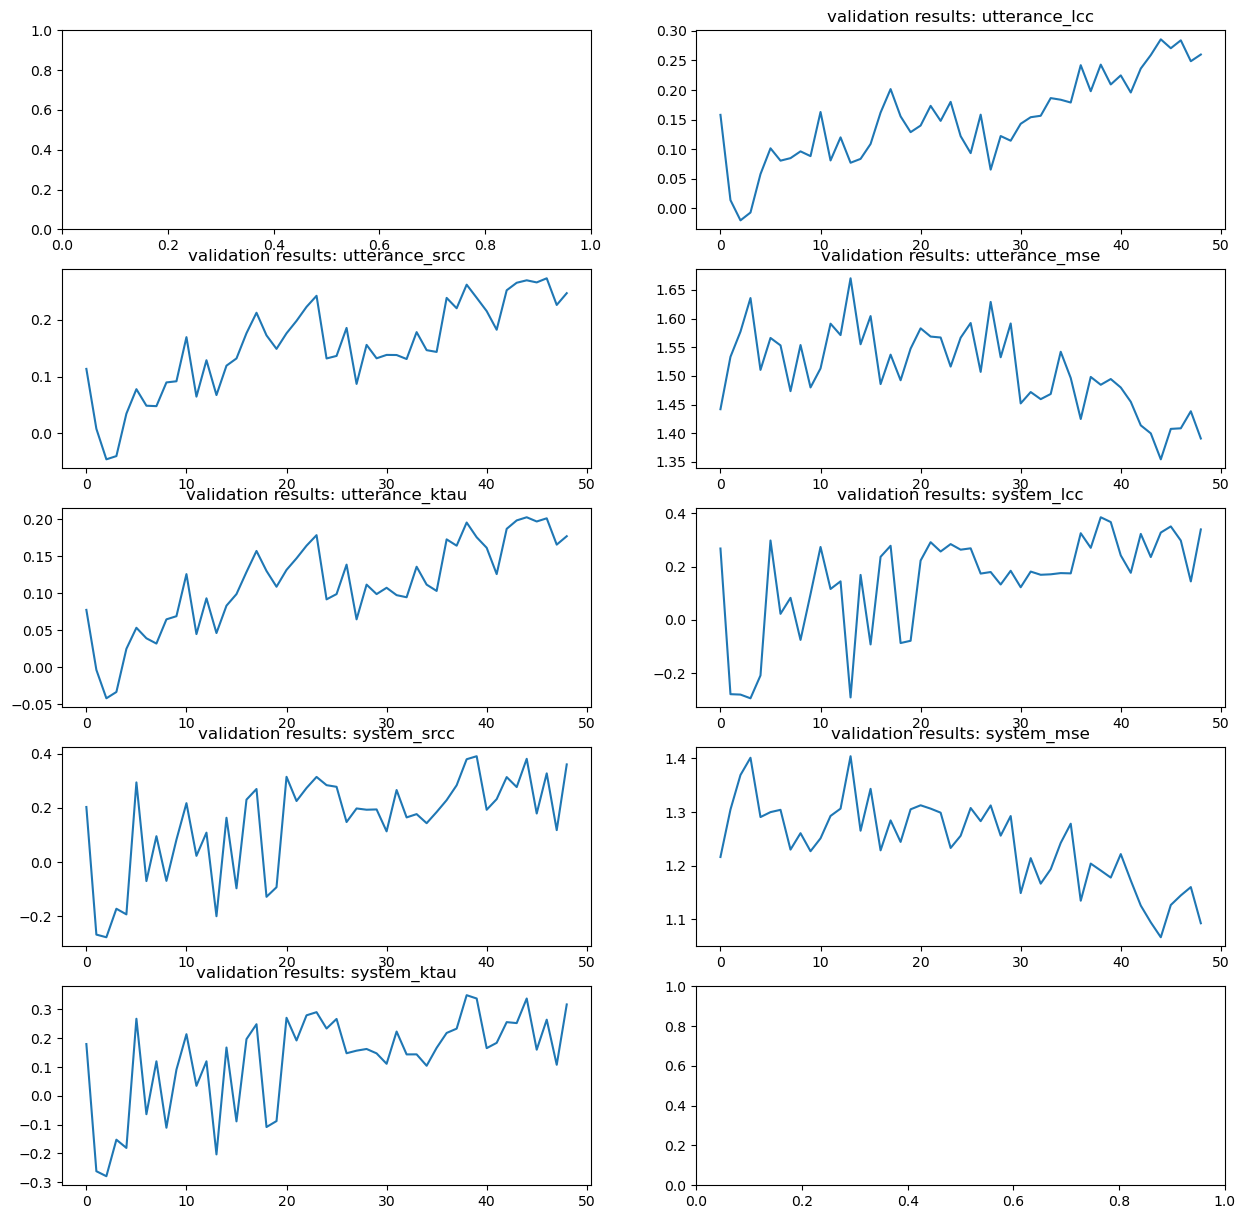

In [10]:
plot_columns('runs/prod/mosnet/validation.csv', 'validation results')

In [6]:
# test baseline MOSNet model
from src.test import test

## TODO: make sure test infers model device

test(
    model_path='pretrained/mosnet.pt',
    data_path=TEST_PATH,
    transcripts_path=TRANSCRIPTS_PATH,
    audios_path=AUDIOS_PATH,
    device=DEVICE,
    runs_dir='runs/prod/mosnet'
)

2024-01-15 11:13:22.897133 :: MOSNET TEST :: METRICS :: 
UTTERANCE :: { lcc: 0.0852, srcc: 0.0143, mse: 1.5498, ktau: 0.0159 } :: SYSTEM :: { lcc: 0.2055, srcc: 0.2267, mse: 1.8255, ktau: 0.1716 }
   system_id listener_id  mos_score  predicted_score
0          4           0        1.0         3.292457
1          1           2        4.0         2.632046
2          0           3        4.0         3.076097
3          0           3        4.0         2.799073
4          3           3        2.0         2.826967
5          1           3        5.0         3.168659
6          0           0        4.0         3.353747
7          1           3        5.0         3.041526
8          0           5        4.0         2.663632
9          0           0        3.0         3.391281
10         0           2        5.0         2.803634
11         2           3        5.0         2.893285
12         0           3        5.0         2.623276
13         4           0        5.0         3.722097
14      

In [4]:
# define MOSNet model with prosody alignment

'''
model = ProsAlignMOSNet(
    stft_params=MOSNET_STFT_PARAMS,
    model_params={
        'pros_align_embedding_size': 64,
        'pros_align_ff_dim': 128,
        'pros_align_ff_dropout': 0.1,
        'pros_align_bigru_dim': 128,
        **BASELINE_MOSNET_PARAMS
    }
).to(DEVICE)
'''

'2.0.3'